# 朴素贝叶斯
### 朴素：在整个形式化过程中只做最原始、最简单的假设
### 优点：在数据较少的情况下仍然有效，可以处理多类别问题
### 缺点：对于输入数据的准备方式较为敏感
### 适用数据类型：标称型数据
### 核心思想：选择具有最高概率的决策
### 贝叶斯概率引入先验知识和逻辑推理来处理不确定命题
### 频数概率只从数据本身获得结论，并不考虑逻辑推理和先验知识

### 使用条件概率来分类：
### p(c|x,y)表示点(x,y)所属类别c的概率
### p(c|x,y)=p(x,y|c)p(c)/p(x,y)
### 然后将所有p(c|x,y)求出选择其取最大值时的类别

##### 数据搜集：本章节使用RSS源
##### 准备数据：需要数值型或者布尔型数据
##### 分析数据：有大量特征时，绘制特征作用不大，此时使用直方图效果较好
##### 训练算法：计算不同的独立特征的条件概率
##### 测试算法：计算错误率
##### 使用算法：文档分类

##### 样本数会随着特征数目增大而迅速增大

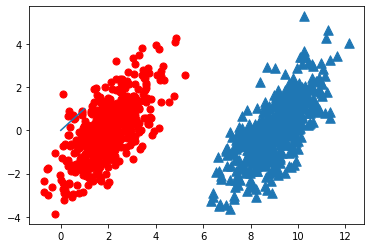

In [1]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

n = 1000 #number of points to create
xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
fw = open('testSet.txt','w')
for i in range(n):
    [r0,r1] = random.standard_normal(2)
    myClass = random.uniform(0,1)
    if (myClass <= 0.5):
        fFlyer = r0 + 9.0
        tats = 1.0*r1 + fFlyer - 9.0
        xcord0.append(fFlyer)
        ycord0.append(tats)
    else:
        fFlyer = r0 + 2.0
        tats = r1+fFlyer - 2.0
        xcord1.append(fFlyer)
        ycord1.append(tats)
    #fw.write("%f\t%f\t%d\n" % (fFlyer, tats, classLabel))

fw.close()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(xcord,ycord, c=colors, s=markers)
ax.scatter(xcord0,ycord0, marker='^', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.plot([0,1], label='going up')
plt.show()

<ipython-input-132-3d49f24d1bdc>:7: RuntimeWarning: divide by zero encountered in log
  logS = log(s)


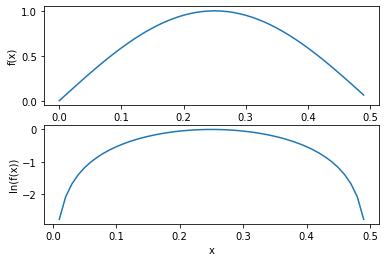

In [132]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

t = arange(0.0, 0.5, 0.01)
s = sin(2*pi*t)
logS = log(s)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t,s)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')

ax = fig.add_subplot(212)
ax.plot(t,logS)
ax.set_ylabel('ln(f(x))')
ax.set_xlabel('x')
plt.show()

### 准备数据：从文本中构建词向量：
### 朴素贝叶斯分类器通常有两种实现方式：
##### 一种基于贝努利模型实现，不考虑词在文档中出现次数，只考虑是否出现
##### 多项式模型实现，考虑词在文档中出现次数
### 采用第一种方式实现

In [125]:


from numpy import *

def loadDataSet():
    postingList=[['my', 'dog', 'has', 'flea', 'problems', 'help', 'please'],
                 ['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid'],
                 ['my', 'dalmation', 'is', 'so', 'cute', 'I', 'love', 'him'],
                 ['stop', 'posting', 'stupid', 'worthless', 'garbage'],
                 ['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him'],
                 ['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']]
    # 1表示侮辱性文字，0代表正常言论
    classVec = [0,1,0,1,0,1]    #1 is abusive, 0 not
    return postingList,classVec

def createVocabList(dataSet):
    # 存放在所有文档中出现的不重复词
    vocabSet=set([])
    for document in dataSet:
        # 创建两个集合的并集
        vocabSet=vocabSet|set(document)
    return list(vocabSet)

# 该函数输入为：词汇表和想要检查的所有单词
# 每一个单词构建一个特征
def setOfWords2Vec(vocabList,inputSet):
    # 词向量
    returnVec=[0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)]=1
        else:
            print('the world: %s is not in my Vocabulary!'%world)
    return returnVec

# 测试
listOPosts,listClasses=loadDataSet()
myVocabList=createVocabList(listOPosts)
# myVocabList
# setOfWords2Vec(myVocabList,listOPosts[0])

# 训练算法：从词向量计算概率
# p(c|w)=p(w|c)p(c)/p(w)
# c表示类别，w表示该词汇的向量
### 伪代码如下：
##### 1.计算每个类别中的文档数目
##### 2.对每篇训练文档：
          对每个类别：
              如果词条出现在文档中->增加该词条的计数器
              增加所有词条的计数值
          对每个类别：
              对每个词条：
                  将该词条的数目除以总词条的数目得到条件概率
          返回每个类别的条件概率

In [17]:


# 函数输入为文档矩阵，每篇文档类别所构成的向量
def trainNB0(trainMatrix,trainCategory):
    numTrainDocs = len(trainMatrix)
    numWords = len(trainMatrix[0])
    # 初始化概率
    pAbusive = sum(trainCategory)/float(numTrainDocs)
    p0Num = ones(numWords); p1Num = ones(numWords)      #change to ones() 
    p0Denom = 2.0; p1Denom = 2.0                        #change to 2.0
    for i in range(numTrainDocs):
        # 向量相加
        if trainCategory[i] == 1:
            p1Num += trainMatrix[i]
            p1Denom += sum(trainMatrix[i])
        else:
            p0Num += trainMatrix[i]
            p0Denom += sum(trainMatrix[i])
    # 对每个元素做除法
    p1Vect = log(p1Num/p1Denom)          #change to log()
    p0Vect = log(p0Num/p0Denom)          #change to log()
    # 返回两个向量和一个概率
    return p0Vect,p1Vect,pAbusive

# 测试：
listOPosts,listClasses=loadDataSet()
myVocabList=createVocabList(listOPosts)
trainMat=[]
for postinDoc in listOPosts:
    trainMat.append(setOfWords2Vec(myVocabList,postinDoc))
p0V,p1V,pAb=trainNB0(trainMat,listClasses)
print("词汇为侮辱性概率：%f"%pAb)

词汇为侮辱性概率：0.500000


In [20]:
# 测试算法：根据实际情况修改分类器
# 在计算多个概率乘积时，为了防止因为其中一个概率为0导致结果为0，可以采用初始化每个词汇出现数为1，将分母初始化为2
# p0Num = ones(numWords); 
# p1Num = ones(numWords)      #change to ones() 
# p0Denom = 2.0; p1Denom = 2.0

# 由于太多太小的数相乘会导致下溢出
# 可以通过取对数来避免下溢出或者浮点数舍入导致的错误
# p1Vect = log(p1Num/p1Denom)          #change to log()
# p0Vect = log(p0Num/p0Denom)          #change to log()

# 朴素贝叶斯分类函数
### 输入参数分别为：待分类变量、使用trainNB0所得三个概率
def classifyNB(vec2Classify, p0Vec, p1Vec, pClass1):
    # 对应元素相乘
    p1 = sum(vec2Classify * p1Vec) + log(pClass1)    #element-wise mult
    p0 = sum(vec2Classify * p0Vec) + log(1.0 - pClass1)
    if p1 > p0:
        return 1
    else: 
        return 0

def testingNB():
    listOPosts,listClasses = loadDataSet()
    myVocabList = createVocabList(listOPosts)
    trainMat=[]
    for postinDoc in listOPosts:
        trainMat.append(setOfWords2Vec(myVocabList, postinDoc))
    p0V,p1V,pAb = trainNB0(array(trainMat),array(listClasses))
    testEntry = ['love', 'my', 'dalmation']
    thisDoc = array(setOfWords2Vec(myVocabList, testEntry))
    print(testEntry,'classified as: ',classifyNB(thisDoc,p0V,p1V,pAb))
    testEntry = ['stupid', 'garbage']
    thisDoc = array(setOfWords2Vec(myVocabList, testEntry))
    print(testEntry,'classified as: ',classifyNB(thisDoc,p0V,p1V,pAb))
    
# 测试
testingNB()

['love', 'my', 'dalmation'] classified as:  0
['stupid', 'garbage'] classified as:  1


In [21]:
# 文档词袋模型
### 词集模型：每个词汇是否出现当作一个特征
### 在词袋中每个词可以多次出现，在词集中只能出现一次
def bagOfWords2VecMN(vocabList, inputSet):
    returnVec = [0]*len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] += 1
    return returnVec


# 案例1：使用朴素贝叶斯过滤垃圾邮件
### 使用数据：提供文本文件
### 准备数据：将文本数据解析为词条向量
### 分析数据：检查词条确保解析的正确性
### 训练算法：使用trainNB0进行训练
### 测试算法：使用分类函数和，并构建一个新的测试函数用于计算文档集的错误率
### 使用算法：构建一个完整程序对一组文档进行分类，将错分文档输出到屏幕上

##### 准备数据：切分文档
##### 使用re模块的字符匹配进行处理

In [101]:

import re
s='I love i, not you!'
regEx=re.compile(r'\W*')
listOfTokens=regEx.split(s)
res=[token for token in listOfTokens if len(token)>0]
res

# 测试算法：使用朴素贝叶斯进行交叉验证
# 接受一个大的字符串，将其解析为字符串列表，并去掉长度少于2的字符串，将其转换为小写字符
def textParse(bigString):    #input is big string, #output is word list
    import re
    listOfTokens = re.split('\W+', bigString)
    return [tok.lower() for tok in listOfTokens if len(tok) > 2] 

# 对贝叶斯垃圾文件进行自动化处理
def spamTest():
    docList=[]; classList = []; fullText =[]
    for i in range(1,26):
        wordList = textParse(open(r'email/spam/%d.txt' % i,encoding='ISO-8859-15').read())
        # print(wordList,end=" ")
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(1)
        wordList = textParse(open(r'email/ham/%d.txt' % i,encoding='ISO-8859-15').read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(0)
    # print(docList)
    vocabList = createVocabList(docList)#create vocabulary
    # 构建测试集和训练集
    trainingSet = list(range(50));
    testSet=[]           #create test set
    # 随机选择数据的一部分作为训练集，余下部分作为测试机的过程叫：留存交叉验证
    # 可以经过多次迭代求平均错误率
    for i in range(10):
        randIndex = int(random.uniform(0,len(trainingSet)))
        testSet.append(trainingSet[randIndex])
        del(trainingSet[randIndex])  
    trainMat=[]; 
    trainClasses = []
    for docIndex in trainingSet:#train the classifier (get probs) trainNB0
        trainMat.append(bagOfWords2VecMN(vocabList, docList[docIndex]))
        trainClasses.append(classList[docIndex])
    p0V,p1V,pSpam = trainNB0(array(trainMat),array(trainClasses))
    errorCount = 0
    # 对测试集进行分类，如果邮件分类错误，则错误数加1
    for docIndex in testSet:        #classify the remaining items
        wordVector = bagOfWords2VecMN(vocabList, docList[docIndex])
        if classifyNB(array(wordVector),p0V,p1V,pSpam) != classList[docIndex]:
            errorCount += 1
            print("classification error",docList[docIndex])
    print('the error rate is: ',float(errorCount)/len(testSet))
    #return vocabList,fullText

# 测试：
spamTest()

classification error ['home', 'based', 'business', 'opportunity', 'knocking', 'your', 'door', 'don', 'rude', 'and', 'let', 'this', 'chance', 'you', 'can', 'earn', 'great', 'income', 'and', 'find', 'your', 'financial', 'life', 'transformed', 'learn', 'more', 'here', 'your', 'success', 'work', 'from', 'home', 'finder', 'experts']
the error rate is:  0.1


# 案例2：使用朴素贝叶斯分类器从个人广告中获取区域倾向
### 搜集数据：从RSS源搜集内容
### 准备数据：将文本数据解析为词条向量
### 分析数据：检查词条确保解析的准确性
### 训练算法：使用trainNB0函数
### 测试算法：观察错误率，确保分类器可用，可以修改切分程序，降低错误率从而提高分类结果
### 使用算法：构建一个完整程序，封装所有内容，给定两个RSS源，显示常用词

In [126]:

import feedparser
ny=feedparser.parse('http://newyork.craigslist.org/stp/index.rss')
ny

# 因为rss数据有误，该程序运行会报错
def calcMostFreq(vocabList,fullText):
    import operator
    # 计算出现频率
    freqDict = {}
    for token in vocabList:
        freqDict[token]=fullText.count(token)
    sortedFreq = sorted(freqDict.items(), key=operator.itemgetter(1), reverse=True) 
    return sortedFreq[:30]       

def localWords(feed1,feed0):
    import feedparser
    docList=[]; classList = []; fullText =[]
    minLen = min(len(feed1['entries']),len(feed0['entries']))
    # 每次访问一条RSS源
    for i in range(minLen):
        wordList = textParse(feed1['entries'][i]['summary'])
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(1) #NY is class 1
        wordList = textParse(feed0['entries'][i]['summary'])
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(0)
    vocabList = createVocabList(docList)#create vocabulary
    top30Words = calcMostFreq(vocabList,fullText)   #remove top 30 words
    # 去掉出现次数最多的词
    for pairW in top30Words:
        if pairW[0] in vocabList: vocabList.remove(pairW[0])
    trainingSet = list(range(2*minLen))
    # print(trainingSet)
    testSet=[]           #create test set
    for i in range(20):
        randIndex = int(random.uniform(0,len(trainingSet)))
        #print(randIndex)
        testSet.append(trainingSet[randIndex])
        del(trainingSet[randIndex])  
    trainMat=[]; trainClasses = []
    for docIndex in trainingSet:#train the classifier (get probs) trainNB0
        trainMat.append(bagOfWords2VecMN(vocabList, docList[docIndex]))
        trainClasses.append(classList[docIndex])
    p0V,p1V,pSpam = trainNB0(array(trainMat),array(trainClasses))
    errorCount = 0
    for docIndex in testSet:        #classify the remaining items
        wordVector = bagOfWords2VecMN(vocabList, docList[docIndex])
        if classifyNB(array(wordVector),p0V,p1V,pSpam) != classList[docIndex]:
            errorCount += 1
    print ('the error rate is: ',float(errorCount)/len(testSet))
    return vocabList,p0V,p1V

# 测试
ny=feedparser.parse('http://newyork.craigslist.org/stp/index.rss')
sf=feedparser.parse('http://sfbay.craigslist.org/stp/index.rss')
#vocabList,pSf,pNY=localWords(ny,sf)
#vocabList,pSf,pNY=localWords(ny,sf)

# 分析数据：显示地域相关词汇
def getTopWords(ny,sf):
    import operator
    vocabList,p0V,p1V=localWords(ny,sf)
    topNY=[]; topSF=[]
    for i in range(len(p0V)):
        if p0V[i] > -6.0 : topSF.append((vocabList[i],p0V[i]))
        if p1V[i] > -6.0 : topNY.append((vocabList[i],p1V[i]))
    sortedSF = sorted(topSF, key=lambda pair: pair[1], reverse=True)
    print("SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**")
    for item in sortedSF:
        print(item[0])
    sortedNY = sorted(topNY, key=lambda pair: pair[1], reverse=True)
    print("NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**")
    for item in sortedNY:
        print(item[0])
# getTopWords(ny,sf)


# 本章小结：对于分类而言,使用概率有时比硬性规则更有效 
### 独立性假设：一个词出现概率并不依赖于文档中的其他词
### 可以通过取对数的方式解决数据下溢的问题
### 词袋模型在解决文档分类问题上比词集模型有所提高，还可以通过移除停用词和对分类器进行优化来提高模型
